In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def image_to_vector(image_path):
    image = Image.open(image_path)
    image_data = np.asarray(image)
    return image_data.flatten()

In [3]:
np.random.seed(8)

fig_size = (32, 32)
vector_dimension = fig_size[0] * fig_size[1]

choice = [i * 7 % 68 for i in range(1, 25 + 1)]
pic_root_folder = "PIE"
selfish_folder = "0"
train_set_name, test_set_name = [], []
for i in choice:
    images = [f'{i}/{filename}' for filename in os.listdir(f'{pic_root_folder}/{i}')]
    np.random.shuffle(images)
    train_size = int(len(images) * 0.7)
    train_set_name += images[:train_size]
    test_set_name += images[train_size:]

self_images = [f'{selfish_folder}/{filename}' for filename in os.listdir(f'{pic_root_folder}/{selfish_folder}')]
np.random.shuffle(self_images)
selfish_train_set_name = self_images[:7]
selfish_test_set_name = self_images[7:]
train_set_name += selfish_train_set_name

# Generate the label for each set
train_set_label = np.array([int(i.split('/')[0]) for i in train_set_name])
test_set_label = np.array([int(i.split('/')[0]) for i in test_set_name])
selfish_test_set_label = np.array([int(i.split('/')[0]) for i in selfish_test_set_name]) # Mark selfish as type

# Read and transform image data
train_set_data = np.zeros((len(train_set_name), vector_dimension))
test_set_data = np.zeros((len(test_set_name), vector_dimension))
selfish_test_set_data = np.zeros((len(selfish_test_set_name), vector_dimension))
for i in range(len(train_set_name)):
    train_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{train_set_name[i]}')
for i in range(len(test_set_name)):
    test_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{test_set_name[i]}')
for i in range(len(selfish_test_set_name)):
    selfish_test_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{selfish_test_set_name[i]}')

In [4]:
def compute_scatter_matrices(X, y):
    _, m = X.shape
    classes = np.unique(y)
    global_mean = np.mean(X, axis=0).reshape(-1, 1)

    S_w = np.zeros((m, m))
    S_b = np.zeros((m, m))
    for i in classes:
        data_i = X[y == i]
        mean_i = np.mean(data_i, axis=0).reshape(-1, 1)
        scatter_in_class = np.zeros((m, m))
        for x in data_i:
            x = x.reshape(-1, 1)
            scatter_in_class += (x - mean_i) @ (x - mean_i).T
        S_w += scatter_in_class
        S_b += data_i.shape[0] * (mean_i - global_mean) @ (mean_i - global_mean).T

    return S_w, S_b

class LDA:
    def __init__(self, X, y):
        S_w, S_b = compute_scatter_matrices(train_set_data, train_set_label)
        _, eigenvectors = np.linalg.eig(np.linalg.inv(S_w) @ S_b)
        self.eigenvec = eigenvectors.real
    
    def transform(self, X, dimension):
        return X @ self.eigenvec[:,:dimension]

In [5]:
lda = LDA(train_set_data, train_set_label)

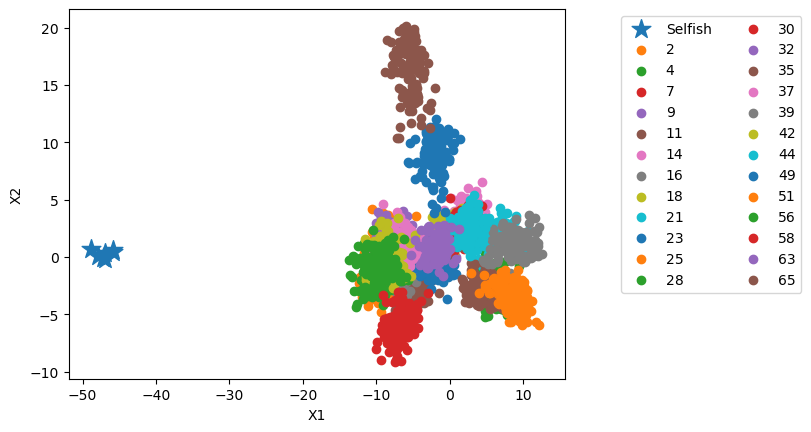

In [6]:
labels_in_train_set = np.unique(train_set_label)
X_2d = lda.transform(train_set_data, 2)
plt.scatter(X_2d[train_set_label==0,0], X_2d[train_set_label==0,1], label = 'Selfish', marker='*', s = 200)
for i in labels_in_train_set[1:]:
    plt.scatter(X_2d[train_set_label==i,0], X_2d[train_set_label==i,1], label = i)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(ncol=2, bbox_to_anchor=(1.1, 1))
plt.show()

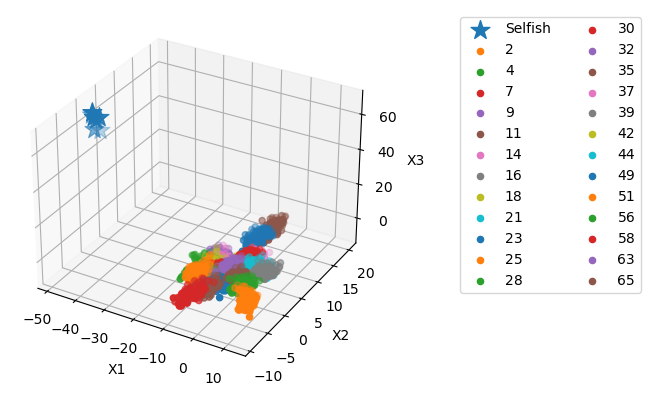

In [7]:
X_3d = lda.transform(train_set_data, 3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_3d[train_set_label==0,0], X_3d[train_set_label==0,1], X_3d[train_set_label==0,2], label = 'Selfish', marker='*', s = 200)
for i in labels_in_train_set[1:]:
    ax.scatter(X_3d[train_set_label==i,0], X_3d[train_set_label==i,1], X_3d[train_set_label==i,2], label = i)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.legend(ncol=2, bbox_to_anchor=(1.2, 1))
plt.show()

In [8]:
class NearstNeighbor:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def compute_distance(A, B):
        distances = np.zeros((A.shape[0], B.shape[0]))
        for i, row_A in enumerate(A):
            for j, row_B in enumerate(B):
                distances[i, j] = np.linalg.norm(row_A - row_B)
        return distances
    
    def classify(self, X):
        distance = NearstNeighbor.compute_distance(X, self.X)
        index = np.argmin(distance, axis = 1)
        return self.y[index]

In [9]:
for d in [2, 3, 9]:
    X_train = lda.transform(train_set_data, d)
    X_test_PIE = lda.transform(test_set_data, d)
    X_test_Selfish = lda.transform(selfish_test_set_data, d)
    NN = NearstNeighbor(X_train, train_set_label)
    predict_result_PIE = NN.classify(X_test_PIE)
    predict_result_Selfish = NN.classify(X_test_Selfish)
    accuary_PIE = np.sum(predict_result_PIE == test_set_label)/predict_result_PIE.size
    accuary_Selfish = np.sum(predict_result_Selfish == selfish_test_set_label)/predict_result_Selfish.size
    print(f'Dimension {d}: Accuracy on PIE = {accuary_PIE}')
    print(f'Dimension {d}: Accuracy on Selfish = {accuary_Selfish}')
    print()

Dimension 2: Accuracy on PIE = 0.35307692307692307
Dimension 2: Accuracy on Selfish = 1.0

Dimension 3: Accuracy on PIE = 0.5638461538461539
Dimension 3: Accuracy on Selfish = 1.0

Dimension 9: Accuracy on PIE = 0.9092307692307692
Dimension 9: Accuracy on Selfish = 1.0

